In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import scikitplot as skplt

In [2]:
data = pd.read_excel("D:\\Ayesha\\IBA Data Science\\Semester 3\\ML II\\default of credit card clients.xls",header=1)

In [3]:
data = data.drop('ID',axis=1)

In [4]:
data.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [5]:
#XGBoost, RF, SVM and LR

In [6]:
X=data.drop('default payment next month',axis=1)
Y=data['default payment next month']

In [7]:
def validationmetrics(model, testX, testY, verbose=True):  
    global predictions
    
    predictions = model.predict(testX)
    
    if model.__class__.__module__.startswith('lightgbm'):
        for i in range(0, predictions.shape[0]):
            predictions[i]= 1 if predictions[i] >= 0.5 else 0
    
    #Accuracy
    accuracy = accuracy_score(testY, predictions)*100
    
    result1 = classification_report(testY, predictions)
    print("Classification Report:",)
    print (result1)
    
    #Precision
    precision = precision_score(testY, predictions, pos_label=1, labels=[0,1])*100
    
    #Recall
    recall = recall_score(testY, predictions,pos_label=1,labels=[0,1])*100
    
    #get FPR (specificity) and TPR (sensitivity)
    fpr , tpr, _ = roc_curve(testY, predictions)
    
    #AUC
    auc_val = auc(fpr, tpr)
    
    #F-Score
    f_score = f1_score(testY, predictions)
    

    if verbose:
        print("Prediction Vector: \n", predictions)
        print("\n Accuracy: \n", accuracy)
        print("\n Precision of event Happening: \n", precision)
        print("\n Recall of event Happening: \n", recall)
        print("\n AUC: \n",auc_val)
        print("\n F-Score:\n", f_score)
        #confusion Matrix
        print("\n Confusion Matrix: \n", confusion_matrix(testY, predictions,labels=[0,1]))
    
    res_map = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "auc_val": auc_val,
                "f_score": f_score,
                "model_obj": model
              }
    
    return res_map

In [8]:
def LogReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LogisticRegression()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def SVM(trainX, testX, trainY, testY, svmtype="SVC", verbose=True, clf=None):
    # for one vs all
    if not clf:
        if svmtype == "Linear":
            clf = svm.LinearSVC()
        else:
            clf = svm.SVC()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def RandomForest(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = RandomForestClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def XgBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = XGBClassifier(random_state=1,learning_rate=0.01)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

# Random Forest Selection

In [9]:
model= RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

PAY_0        0.093571
AGE          0.066619
BILL_AMT1    0.060665
LIMIT_BAL    0.058743
BILL_AMT2    0.054517
BILL_AMT3    0.052130
BILL_AMT4    0.050841
BILL_AMT6    0.050739
BILL_AMT5    0.050346
PAY_AMT1     0.050145
PAY_2        0.048232
PAY_AMT2     0.047292
PAY_AMT6     0.046635
PAY_AMT3     0.045989
PAY_AMT4     0.043852
PAY_AMT5     0.043674
PAY_3        0.028069
PAY_5        0.023493
EDUCATION    0.020444
PAY_4        0.018949
PAY_6        0.018817
MARRIAGE     0.014032
SEX          0.012207
dtype: float64

In [10]:
import matplotlib
import matplotlib.pyplot as plt

def select_features(X_train, y_train, X_test,n):
    # configure to select a subset of features
    fs = SelectFromModel(RandomForestClassifier(n_estimators=100),threshold=-np.inf, max_features=n)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    selected_feat= X_train.columns[(fs.get_support())]
    print(selected_feat)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(5,25,5):
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,n)
    # fit the model
    print ("Logistic Regression From Random Forest Selection")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From Random Forest Selection")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From Random Forest Selection")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From Random Forest Selection")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    
    

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2'], dtype='object')
Logistic Regression From Random Forest Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From Random Forest Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accu

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:08:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.69      0.33      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.64      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.75757575757576

 Precision of event Happening: 
 69.12878787878788

 Recall of event Happening: 
 33.03167420814479

 AUC: 
 0.6439620121330517

 F-Score:
 0.44703000612369864

 Confusion Matrix: 
 [[7364  326]
 [1480  730]]
Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2

C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From Random Forest Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      7690
           1       0.64      0.35      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.64      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accur

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.70      0.33      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.77      0.64      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.84848484848484

 Precision of event Happening: 
 69.76076555023923

 Recall of event Happening: 
 32.98642533936651

 AUC: 
 0.6443859628476778

 F-Score:
 0.44792626728110596

 Confusion Matrix: 
 [[7374  316]
 [1481  729]]
Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT6'],
      dtype='object')
Logistic Regression From Random Forest Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.50      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.64      0.50      0.44      9900
weighted avg       0.72      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 50.0

 Recall of event Happening: 
 0.09049773755656108

 AUC: 
 0.5003224496760793

 F-Score:
 0.001806684733514002

 Confusion Matrix: 
 [[7688    2]
 [2208    2]]
SVM From Random Forest Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From Random Forest Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.65      0.36      0.46      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accur

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.69      0.34      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.75757575757576

 Precision of event Happening: 
 68.73840445269018

 Recall of event Happening: 
 33.52941176470588

 AUC: 
 0.6457354853514878

 F-Score:
 0.4507299270072993

 Confusion Matrix: 
 [[7353  337]
 [1469  741]]
Index(['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Logistic Regression From Random Forest Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From Random Forest Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From Random Forest Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.64      0.36      0.46      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accur

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.68      0.34      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.77777777777779

 Precision of event Happening: 
 68.28828828828829

 Recall of event Happening: 
 34.29864253393665

 AUC: 
 0.6486063466098654

 F-Score:
 0.4566265060240964

 Confusion Matrix: 
 [[7338  352]
 [1452  758]]


Logistic Regression with Random Forest selection performs well on 10 features. the accuracy is 82.8, Precision 87 and recall 91.
SVM with with Random Forest selection performs well on 10 features as accuracy is 81, precision is 83, recall is 94.
RF with random forest selection performs very well on 15 features as accuracy is 85.2, precision is 90 and recall is 90.9.
Xgboost with random forest selection performs well on 10 features as accuracy is 85.2, precision is 88 and recall is 93.
We concluded that LR, SVM, Xgboost with 10 features works really better with Random Forest selection as it is useful in minimizing the features. So if we want to select one model from random forest selection we will choose Xgboost (with 10 features).

# XGBOOST SELECTION

In [11]:
model= XGBClassifier(n_estimators=100,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

[12:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


PAY_0        0.369486
PAY_2        0.133631
PAY_3        0.052888
PAY_4        0.040230
PAY_6        0.037193
PAY_5        0.036620
PAY_AMT2     0.024072
LIMIT_BAL    0.023817
BILL_AMT1    0.022776
PAY_AMT3     0.022579
BILL_AMT2    0.020286
PAY_AMT1     0.019711
EDUCATION    0.019459
PAY_AMT4     0.019295
BILL_AMT3    0.018596
PAY_AMT6     0.018429
BILL_AMT5    0.018013
PAY_AMT5     0.017983
MARRIAGE     0.017965
BILL_AMT6    0.017443
BILL_AMT4    0.016913
AGE          0.016321
SEX          0.016294
dtype: float32

In [12]:
def select_features(X_train, y_train, X_test,n):
    # configure to select a subset of features
    fs = SelectFromModel(XGBClassifier(n_estimators=100),threshold=-np.inf, max_features=n)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    selected_feat= X_train.columns[(fs.get_support())]
    print(selected_feat)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs



# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(5,25,5):
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,n)
    # fit the model
    print ("Logistic Regression From XGboost Selection")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From XGboost Selection")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From XGboost Selection")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From XGboost Selection")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
 

[12:12:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')
Logistic Regression From XGboost Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      7690
           1       0.72      0.22      0.33      2210

    accuracy                           0.81      9900
   macro avg       0.77      0.60      0.61      9900
weighted avg       0.79      0.81      0.76      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.64646464646465

 Precision of event Happening: 
 72.07207207207207

 Recall of event Happening: 
 21.71945701357466

 AUC: 
 0.5965036569794469

 F-Score:
 0.3337969401947149

 Confusion Matrix: 
 [[7504  186]
 [1730  480]]
SVM From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.67      0.36      0.47      2210

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80     

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.66      0.37      0.47      2210

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.7070707070707

 Precision of event Happening: 
 66.28571428571428

 Recall of event Happening: 
 36.742081447963805

 AUC: 
 0.656857351323044

 F-Score:
 0.4727802037845706

 Confusion Matrix: 
 [[7277  413]
 [1398  812]]
[12:12:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Index(['LIMIT_BAL', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'PAY_AMT3'],
      dtype='object')
Logistic Regression From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From XGboost Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\met

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7690
           1       0.60      0.36      0.45      2210

    accuracy                           0.80      9900
   macro avg       0.72      0.64      0.66      9900
weighted avg       0.78      0.80      0.78      9900

Prediction Vector: 
 [0 0 0 ... 0 1 0]

 Accuracy: 


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.68      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.68      9900
weighted avg       0.80      0.82      0.80      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.7979797979798

 Precision of event Happening: 
 67.64705882352942

 Recall of event Happening: 
 35.38461538461539

 AUC: 
 0.6526057817345204

 F-Score:
 0.46464646464646464

 Confusion Matrix: 
 [[7316  374]
 [1428  782]]
[12:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Index(['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4'],
      dtype='object')
Logistic Regression From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.64646464646464

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.49980494148244475

 F-Score:
 0.0

 Confusion Matrix: 
 [[7687    3]
 [2210    0]]
SVM From XGboost Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\met

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7690
           1       0.61      0.35      0.44      2210

    accuracy                           0.81      9900
   macro avg       0.72      0.64      0.66      9900
weighted avg       0.78      0.81      0.78      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.68      0.34      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.68686868686869

 Precision of event Happening: 
 67.64444444444445

 Recall of event Happening: 
 34.43438914027149

 AUC: 
 0.6485048455713185

 F-Score:
 0.4563718140929534

 Confusion Matrix: 
 [[7326  364]
 [1449  761]]
[12:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Index(['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT6'],
      dtype='object')
Logistic Regression From XGboost Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\met

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From XGboost Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From XGboost Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.64      0.35      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 


C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.67      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.75      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.66666666666667

 Precision of event Happening: 
 67.4315975286849

 Recall of event Happening: 
 34.57013574660633

 AUC: 
 0.648858481073734

 F-Score:
 0.4570744839964104

 Confusion Matrix: 
 [[7321  369]
 [1446  764]]


Logistic Regression with xgboost feature selection doesnot perform well on the less number of features it perform well on 20 features with the accuracy 89, precision 79 and recall 98.
SVM with xgboost feature selection perform almost same with more or less features so its better to select with less features. (accuracy 78.4, precision 79, recall 98.48)
RF with xgboost selection performs well on 20 features with accuracy 86.6, precision 90.04 and recall 95.95.
Xgboost with xgboost selection performs well on 10 features with accuracy 84.39, precision 89.16, recall 91.41.
We concluded that from xgboost selection RF model (with 10 features) performs well from all of them.

# RFE SELECTION

In [13]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [14]:
def select_features(X_train, y_train, X_test,n):
    # configure to select a subset of features
    fs = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = n)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    selected_feat= X_train.columns[(fs.get_support())]
    print(selected_feat)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(5,25,5):
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,n)
    # fit the model
    print ("Logistic Regression From RFE Selection")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From RFE Selection")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From RFE Selection")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From RFE Selection")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)

 

Index(['PAY_0', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT6'], dtype='object')
Logistic Regression From RFE Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      7690
           1       0.35      0.05      0.08      2210

    accuracy                           0.77      9900
   macro avg       0.57      0.51      0.48      9900
weighted avg       0.68      0.77      0.69      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 76.75757575757575

 Precision of event Happening: 
 34.98349834983499

 Recall of event Happening: 
 4.796380090497738

 AUC: 
 0.5111730577996929

 F-Score:
 0.08436132113012336

 Confusion Matrix: 
 [[7493  197]
 [2104  106]]
SVM From RFE Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                       

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.69      0.32      0.44      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.64      0.66      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.61616161616162

 Precision of event Happening: 
 69.11764705882352

 Recall of event Happening: 
 31.90045248868778

 AUC: 
 0.6390211181001358

 F-Score:
 0.43653250773993807

 Confusion Matrix: 
 [[7375  315]
 [1505  705]]
Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT3', 'PAY_AMT5'],
      dtype='object')
Logistic Regression From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From RFE Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.64      0.34      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.64      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.70      0.33      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.64      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.81818181818183

 Precision of event Happening: 
 69.7495183044316

 Recall of event Happening: 
 32.76018099547511

 AUC: 
 0.6433847801399243

 F-Score:
 0.4458128078817734

 Confusion Matrix: 
 [[7376  314]
 [1486  724]]
Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Logistic Regression From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From RFE Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.65      0.35      0.46      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.70      0.33      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.77      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.87878787878789

 Precision of event Happening: 
 69.77186311787072

 Recall of event Happening: 
 33.212669683257914

 AUC: 
 0.6453871455554313

 F-Score:
 0.4500306560392397

 Confusion Matrix: 
 [[7372  318]
 [1476  734]]
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_4', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Logistic Regression From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.33      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.56      0.50      0.44      9900
weighted avg       0.68      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.66666666666666

 Precision of event Happening: 
 33.33333333333333

 Recall of event Happening: 
 0.04524886877828054

 AUC: 
 0.5000962053321879

 F-Score:
 0.0009037505648441032

 Confusion Matrix: 
 [[7688    2]
 [2209    1]]
SVM From RFE Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From RFE Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      7690
           1       0.64      0.35      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.68      0.34      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.73737373737374

 Precision of event Happening: 
 68.33941605839416

 Recall of event Happening: 
 33.89140271493213

 AUC: 
 0.6468952450441015

 F-Score:
 0.45311554748941324

 Confusion Matrix: 
 [[7343  347]
 [1461  749]]


Logistic Regression with RFE selection perform well with 10 features with an accuracy of 79, precision 79.67, recall 98.9.
SVM with RFE selection perform well with 5 features with an accuracy 78, precision 79, recall 98.
RF with RFE selection perform well with 10 features with an accuracy of 86.6, precision 91.45, recall 91.9.
Xgboost with RFE selection performs well with 20 features with an accuracy of 82.39, precision 88.5, recall 89.39
We concluded that from RFE selection RF performs (with 10 features) model performs well from all of them.

# LASSO SELECTION

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [16]:
def select_features(X_train, y_train, X_test,n):
    # configure to select a subset of features
    # Use L1 penalty
    estimator = LassoCV(cv=5, normalize = True)
    fs = SelectFromModel(estimator,threshold=-np.inf, max_features=n)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    selected_feat= X_train.columns[(fs.get_support())]
    print(selected_feat)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(5,25,5):
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,n)
    # fit the model
    print ("Logistic Regression From L1 Based Feature Selection")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From L1 Based Feature Selection")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From L1 Based Feature Selection")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From L1 Based Feature Selection")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2'], dtype='object')
Logistic Regression From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.72      0.23      0.35      2210

    accuracy                           0.81      9900
   macro avg       0.77      0.60      0.62      9900
weighted avg       0.79      0.81      0.77      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.83838383838385

 Precision of event Happening: 
 72.32524964336662

 Recall of event Happening: 
 22.941176470588236

 AUC: 
 0.6020920982177007

 F-Score:
 0.34833390587427

 Confusion Matrix: 
 [[7496  194]
 [1703  507]]
SVM From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.70      0.31      0.43      2210

    accuracy          

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.69      0.32      0.44      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.64      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.71717171717172

 Precision of event Happening: 
 69.34235976789168

 Recall of event Happening: 
 32.44343891402715

 AUC: 
 0.6416060112151292

 F-Score:
 0.4420468557336621

 Confusion Matrix: 
 [[7373  317]
 [1493  717]]


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_AMT1'],
      dtype='object')
Logistic Regression From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.71      0.21      0.33      2210

    accuracy                           0.81      9900
   macro avg       0.76      0.59      0.61      9900
weighted avg       0.79      0.81      0.76      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.51515151515152

 Precision of event Happening: 
 71.06446776611695

 Recall of event Happening: 
 21.447963800904976

 AUC: 
 0.594691054375136

 F-Score:
 0.3295099061522419

 Confusion Matrix: 
 [[7497  193]
 [1736  474]]
SVM From L1 Based Feature Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      7690
           1       0.55      0.37      0.44      2210

    accuracy                           0.79      9900
   macro avg       0.69      0.64      0.66      9900
weighted avg       0.77      0.79      0.78      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Ac

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.68      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.68      9900
weighted avg       0.80      0.82      0.80      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.82828282828282

 Precision of event Happening: 
 68.10572687224669

 Recall of event Happening: 
 34.977375565610856

 AUC: 
 0.6513498167097189

 F-Score:
 0.4621823617339312

 Confusion Matrix: 
 [[7328  362]
 [1437  773]]


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5'],
      dtype='object')
Logistic Regression From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      7690
           1       0.67      0.20      0.31      2210

    accuracy                           0.80      9900
   macro avg       0.74      0.59      0.60      9900
weighted avg       0.78      0.80      0.76      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.02020202020202

 Precision of event Happening: 
 67.26190476190477

 Recall of event Happening: 
 20.452488687782804

 AUC: 
 0.5879581521515278

 F-Score:
 0.31367106176266485

 Confusion Matrix: 
 [[7470  220]
 [1758  452]]
SVM From L1 Based Feature Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.65      0.37      0.47      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.66      0.68      9900
weighted avg       0.80      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Ac

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.68      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.68      9900
weighted avg       0.80      0.82      0.80      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.8080808080808

 Precision of event Happening: 
 67.8915135608049

 Recall of event Happening: 
 35.1131221719457

 AUC: 
 0.6517034522121343

 F-Score:
 0.46286907247241277

 Confusion Matrix: 
 [[7323  367]
 [1434  776]]


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')
Logistic Regression From L1 Based Feature Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From L1 Based Feature Selection


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From L1 Based Feature Selection
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.64      0.36      0.46      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Ac

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.68      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.65      0.68      9900
weighted avg       0.80      0.82      0.80      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.87878787878789

 Precision of event Happening: 
 68.40707964601769

 Recall of event Happening: 
 34.977375565610856

 AUC: 
 0.6516749142389776

 F-Score:
 0.46287425149700595

 Confusion Matrix: 
 [[7333  357]
 [1437  773]]


Logistic Regression with lasso selection performs well with 5 features with an accuracy of 79, precision 79, recall 100.
SVM with lasso selection performs well with 20 features with an accuracy of 80, precision 85, recall 90.
RF with lasso selection performs well with 20 features with an accuracy of 84, precision 89, recall 90.
Xgboost with lasso selection performs well with 20 features with an accuracy of 80, precision 85, recall 90.
We concluded that lasso selection of less features doesnot perform with classifiers. RF from lasso selection (20 features) performs well from all of them.

# PCA 

[0.28498137 0.17725127 0.0663793  0.05874819 0.04443755 0.04287519
 0.04042738 0.0396448  0.03819943 0.03683116 0.03326009 0.02919461
 0.02486697 0.02271439 0.01759449 0.01140019 0.01062747 0.0081627
 0.00578254 0.00296442 0.0016675  0.00105798 0.00093101]


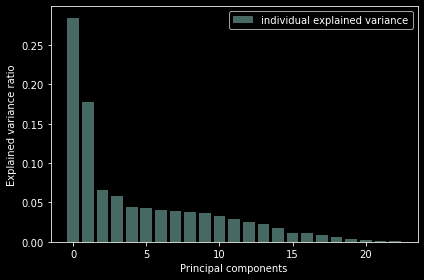

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Explained Variance Ratio of  5  Components:
[0.28498137 0.17725126 0.06637927 0.05874814 0.04443741]


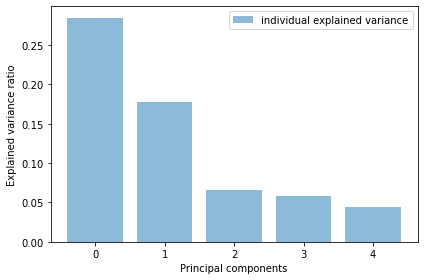

Logistic Regression From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      7690
           1       0.70      0.14      0.23      2210

    accuracy                           0.79      9900
   macro avg       0.75      0.56      0.56      9900
weighted avg       0.78      0.79      0.74      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 79.47474747474747

 Precision of event Happening: 
 70.41284403669725

 Recall of event Happening: 
 13.891402714932127

 AUC: 
 0.5610694973197842

 F-Score:
 0.2320483749055178

 Confusion Matrix: 
 [[7561  129]
 [1903  307]]
SVM From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      7690
           1       0.66      0.23      0.34      2210

    accuracy                           0.80      9900
   macro avg       0.74      0.60      0.61      9900
weighted avg       0.78      0.8

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7690
           1       0.63      0.28      0.38      2210

    accuracy                           0.80      9900
   macro avg       0.73      0.61      0.63      9900
weighted avg       0.78      0.80      0.77      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.25252525252526

 Precision of event Happening: 
 63.212435233160626

 Recall of event Happening: 
 27.601809954751133

 AUC: 
 0.6149271251963824

 F-Score:
 0.38425196850393706

 Confusion Matrix: 
 [[7335  355]
 [1600  610]]
Explained Variance Ratio of  10  Components:
[0.28498137 0.17725127 0.0663793  0.05874819 0.04443755 0.04287519
 0.04042738 0.0396448  0.03819943 0.03683116]


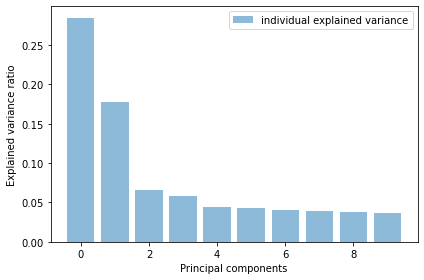

Logistic Regression From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      7690
           1       0.70      0.16      0.26      2210

    accuracy                           0.80      9900
   macro avg       0.75      0.57      0.57      9900
weighted avg       0.78      0.80      0.74      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 79.7070707070707

 Precision of event Happening: 
 70.14028056112225

 Recall of event Happening: 
 15.837104072398189

 AUC: 
 0.5694976139900793

 F-Score:
 0.25839793281653745

 Confusion Matrix: 
 [[7541  149]
 [1860  350]]
SVM From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      7690
           1       0.66      0.25      0.36      2210

    accuracy                           0.80      9900
   macro avg       0.74      0.61      0.62      9900
weighted avg       0.78      0.8

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7690
           1       0.64      0.28      0.39      2210

    accuracy                           0.80      9900
   macro avg       0.73      0.62      0.64      9900
weighted avg       0.78      0.80      0.77      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.36363636363636

 Precision of event Happening: 
 63.57142857142857

 Recall of event Happening: 
 28.190045248868778

 AUC: 
 0.6177382626552671

 F-Score:
 0.3905956112852665

 Confusion Matrix: 
 [[7333  357]
 [1587  623]]
Explained Variance Ratio of  15  Components:
[0.28498137 0.17725127 0.0663793  0.05874819 0.04443755 0.04287519
 0.04042738 0.0396448  0.03819943 0.03683116 0.03326009 0.02919461
 0.02486697 0.02271439 0.01759449]


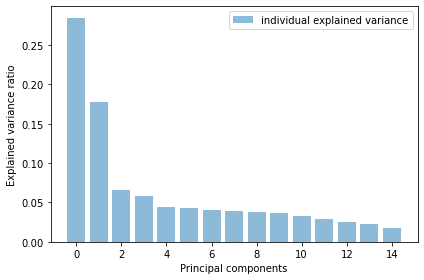

Logistic Regression From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.71      0.22      0.34      2210

    accuracy                           0.81      9900
   macro avg       0.76      0.60      0.61      9900
weighted avg       0.79      0.81      0.76      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.62626262626263

 Precision of event Happening: 
 71.15942028985506

 Recall of event Happening: 
 22.217194570135746

 AUC: 
 0.5981470911861794

 F-Score:
 0.3386206896551724

 Confusion Matrix: 
 [[7491  199]
 [1719  491]]
SVM From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.65      0.34      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.64      0.67      9900
weighted avg       0.79      0.8

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.67      0.34      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.75      0.65      0.67      9900
weighted avg       0.80      0.82      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.55555555555556

 Precision of event Happening: 
 67.23518850987432

 Recall of event Happening: 
 33.89140271493213

 AUC: 
 0.6457248939387699

 F-Score:
 0.45066185318892904

 Confusion Matrix: 
 [[7325  365]
 [1461  749]]
Explained Variance Ratio of  20  Components:
[0.28498137 0.17725127 0.0663793  0.05874819 0.04443755 0.04287519
 0.04042738 0.0396448  0.03819943 0.03683116 0.03326009 0.02919461
 0.02486697 0.02271439 0.01759449 0.01140019 0.01062747 0.0081627
 0.00578254 0.00296442]


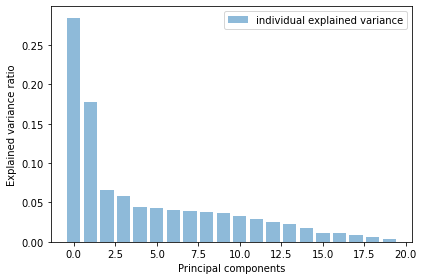

Logistic Regression From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.72      0.22      0.34      2210

    accuracy                           0.81      9900
   macro avg       0.77      0.60      0.61      9900
weighted avg       0.79      0.81      0.77      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.71717171717172

 Precision of event Happening: 
 71.90684133915575

 Recall of event Happening: 
 22.35294117647059

 AUC: 
 0.5992159412529642

 F-Score:
 0.34104245771487746

 Confusion Matrix: 
 [[7497  193]
 [1716  494]]
SVM From PCA
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7690
           1       0.69      0.33      0.45      2210

    accuracy                           0.82      9900
   macro avg       0.76      0.64      0.67      9900
weighted avg       0.80      0.8

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7690
           1       0.66      0.34      0.45      2210

    accuracy                           0.81      9900
   macro avg       0.75      0.65      0.67      9900
weighted avg       0.80      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.4040404040404

 Precision of event Happening: 
 66.14173228346458

 Recall of event Happening: 
 34.20814479638009

 AUC: 
 0.6458781752172712

 F-Score:
 0.4509394572025053

 Confusion Matrix: 
 [[7303  387]
 [1454  756]]


In [20]:
from sklearn.decomposition import PCA
def select_features(X_train, X_test,n):
    global pca
    # configure to select a subset of features
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    pca = PCA(n_components = n)
    X_train_fs = pca.fit_transform(X_train)
    X_test_fs = pca.transform(X_test)
    return X_train_fs, X_test_fs
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(5,25,5):
    X_train_fs, X_test_fs = select_features(X_train, X_test,n)
    
    print ("Explained Variance Ratio of ",n," Components:")
    explained_variance = pca.explained_variance_ratio_
    print(explained_variance)
    
    plt.figure(figsize=(6, 4))
    plt.bar(range(n), explained_variance, alpha=0.5, align='center',label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # fit the model
    print ("Logistic Regression From PCA")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From PCA")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From PCA")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From PCA")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    

Logistic Regression with PCA performs well with 5 components with an accuracy of 84, precision 88, recall 93.
SVM with PCA performs well with 10 components with an accuracy of 84, precision 86, recall 95.
RF with PCA performs well with 10 components with an accuracy of 86, precision 89, recall 93.
Xgboost with PCA performs well with 20 components with an accuracy of 83, precision 88, recall 90.
We concluded that PCA is useful in dimensionality reduction of the dataset as Logistic Regression with 5 componenets perform well from all of them.

# LDA

[1.]


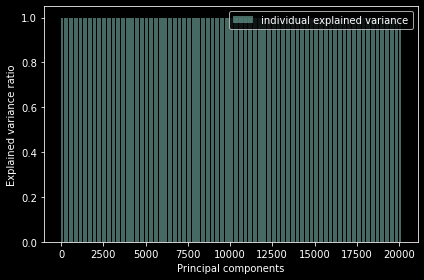

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
sc = StandardScaler()
y_train = y_train.to_numpy(dtype='int')
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
lda = LinearDiscriminantAnalysis()
X_train = lda.fit_transform(X_train,y_train)
X_test = lda.transform(X_test)
explained_variance = lda.explained_variance_ratio_
print(explained_variance)
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(X_train)), explained_variance, alpha=0.5, align='center',label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Explained Variance Ratio
[0.28498137 0.17725127 0.0663793  0.05874819 0.04443755 0.04287519
 0.04042738 0.0396448  0.03819943 0.03683116 0.03326009 0.02919461
 0.02486697 0.02271439 0.01759449 0.01140019 0.01062747 0.0081627
 0.00578254 0.00296442]


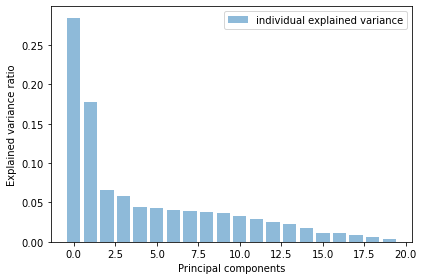

Logistic Regression From LDA
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7690
           1       0.71      0.23      0.34      2210

    accuracy                           0.81      9900
   macro avg       0.76      0.60      0.62      9900
weighted avg       0.79      0.81      0.77      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 80.7070707070707

 Precision of event Happening: 
 71.42857142857143

 Recall of event Happening: 
 22.624434389140273

 AUC: 
 0.6001182707753503

 F-Score:
 0.3436426116838488

 Confusion Matrix: 
 [[7490  200]
 [1710  500]]
SVM From LDA
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7690
           1       0.67      0.35      0.46      2210

    accuracy                           0.82      9900
   macro avg       0.75      0.65      0.68      9900
weighted avg       0.80      0.82

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7690
           1       0.65      0.36      0.46      2210

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.68      9900
weighted avg       0.80      0.81      0.79      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 81.41414141414141

 Precision of event Happening: 
 65.1888341543514

 Recall of event Happening: 
 35.92760180995475

 AUC: 
 0.6520697385686295

 F-Score:
 0.46324387397899647

 Confusion Matrix: 
 [[7266  424]
 [1416  794]]


{'accuracy': 81.41414141414141,
 'precision': 65.1888341543514,
 'recall': 35.92760180995475,
 'auc_val': 0.6520697385686295,
 'f_score': 0.46324387397899647,
 'model_obj': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.01, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

In [22]:
def select_features(X_train, X_test,y_train):
    global lda
    # configure to select a subset of features
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    y_train = y_train.to_numpy(dtype='int')
    lda = LinearDiscriminantAnalysis(solver='svd')
    X_train_fs = lda.fit_transform(X_train,y_train)
    X_test_fs = lda.transform(X_test)
    return X_train_fs, X_test_fs
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection

X_train_fs, X_test_fs  = select_features(X_train, X_test,y_train)
    
print ("Explained Variance Ratio")
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
    
    # fit the model
print ("Logistic Regression From LDA")
LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
print ("SVM From LDA")
SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
print ("RM From LDA")
RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
print ("Xgboost From LDA")
XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    

TSNE doesnot perform on less number of components. It doesnot reduce the dimensionality of dataset. Logistic Regression, Xgboost, RF all perform well with 20 components except SVM.

# TSNE

In [23]:
from sklearn.manifold import TSNE
def select_features(X_train, X_test,n):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    tsne = TSNE(n_components = n)
    X_train_fs = tsne.fit_transform(X_train)
    X_test_fs = tsne.fit_transform(X_test)
    return X_train_fs, X_test_fs
 
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# feature selection
for n in range(1,4):
    X_train_fs, X_test_fs  = select_features(X_train, X_test,n)
    # fit the model
    print ("Logistic Regression From TSNE")
    LogReg(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("SVM From TSNE")
    SVM(X_train_fs, X_test_fs, y_train, y_test, svmtype="SVC", verbose=True, clf=None)
    print ("RM From TSNE")
    RandomForest(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)
    print ("Xgboost From TSNE")
    XgBoost(X_train_fs, X_test_fs, y_train, y_test, verbose=True, clf=None)


C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Logistic Regression From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From TSNE


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
RM From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      7690
           1       0.23      0.23      0.23      2210

    accuracy                           0.65      9900
   macro avg       0.50      0.50      0.50      9900
weighted avg       0.65      0.65      0.65      9900

Prediction Vector: 
 [0 1 0 ... 0 0 0]

 Accuracy: 
 65.282828282

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      7690
           1       0.24      0.11      0.16      2210

    accuracy                           0.72      9900
   macro avg       0.51      0.51      0.50      9900
weighted avg       0.66      0.72      0.68      9900

Prediction Vector: 
 [0 1 0 ... 0 0 0]

 Accuracy: 
 72.32323232323232

 Precision of event Happening: 
 24.42084942084942

 Recall of event Happening: 
 11.447963800904978

 AUC: 
 0.5063295459226004

 F-Score:
 0.1558841651263093

 Confusion Matrix: 
 [[6907  783]
 [1957  253]]


C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Logistic Regression From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.35      0.00      0.01      2210

    accuracy                           0.78      9900
   macro avg       0.56      0.50      0.44      9900
weighted avg       0.68      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.6060606060606

 Precision of event Happening: 
 34.78260869565217

 Recall of event Happening: 
 0.36199095022624433

 AUC: 
 0.5008346621633548

 F-Score:
 0.00716524854455889

 Confusion Matrix: 
 [[7675   15]
 [2202    8]]
SVM From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      7690
           1       0.26      0.11      0.16      2210

    accuracy                           0.73      9900
   macro avg       0.52      0.51      0.50      9900
weighted avg       0.66      

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      7690
           1       0.31      0.20      0.24      2210

    accuracy                           0.72      9900
   macro avg       0.55      0.54      0.54      9900
weighted avg       0.68      0.72      0.70      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 71.86868686868686

 Precision of event Happening: 
 30.508474576271187

 Recall of event Happening: 
 20.361990950226243

 AUC: 
 0.5351649612530818

 F-Score:
 0.24423337856173677

 Confusion Matrix: 
 [[6665 1025]
 [1760  450]]


C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Logistic Regression From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.00      0.00      0.00      2210

    accuracy                           0.78      9900
   macro avg       0.39      0.50      0.44      9900
weighted avg       0.60      0.78      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.67676767676768

 Precision of event Happening: 
 0.0

 Recall of event Happening: 
 0.0

 AUC: 
 0.5

 F-Score:
 0.0

 Confusion Matrix: 
 [[7690    0]
 [2210    0]]
SVM From TSNE


C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\anaconda\lib\site-packages\sklearn\metrics\_classificat

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7690
           1       0.14      0.00      0.00      2210

    accuracy                           0.77      9900
   macro avg       0.46      0.50      0.44      9900
weighted avg       0.63      0.77      0.68      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 77.40404040404042

 Precision of event Happening: 
 13.513513513513514

 Recall of event Happening: 
 0.22624434389140274

 AUC: 
 0.4990505975322008

 F-Score:
 0.004450378282153984

 Confusion Matrix: 
 [[7658   32]
 [2205    5]]
RM From TSNE
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      7690
           1       0.17      0.04      0.06      2210

    accuracy                           0.74      9900
   macro avg       0.47      0.49      0.46      9900
weighted avg       0.64      0.74      0.67      9900

Pr

C:\Users\Hp\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      7690
           1       0.16      0.03      0.05      2210

    accuracy                           0.75      9900
   macro avg       0.46      0.49      0.45      9900
weighted avg       0.64      0.75      0.67      9900

Prediction Vector: 
 [0 0 0 ... 0 0 0]

 Accuracy: 
 74.58585858585859

 Precision of event Happening: 
 15.54054054054054

 Recall of event Happening: 
 3.1221719457013575

 AUC: 
 0.4912285450340984

 F-Score:
 0.05199698568198945

 Confusion Matrix: 
 [[7315  375]
 [2141   69]]


Logistic Regression with TSNE performs well with 1 component with an accuracy of 79, precision 79, recall 100.
SVM with TSNE performs well with 1 component with an accuracy of 79, precision 79, recall 100.
RF with TSNE performs well with 3 components with an accuracy of 70, precision 80.3, recall 82.8.
Xgboost with TSNE performs well with 3 components with an accuracy of 71, precision 82, recall 81.
We concluded that TSNE is useful in dimensionality reduction of the dataset as Logistic Regression with 1 componenet perform well from all of them.